# Analyze and plot methods for hurricane forecast uncertainty
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.1.0
##### date: 14 December 2021

```
conda create --name env-hurr-tfp python=3.9
conda activate env-hurr-tfp
pip install tensorflow==2.7.0
pip install tensorflow-probability==0.15.0
pip install --upgrade numpy scipy pandas statsmodels matplotlib seaborn 
pip install --upgrade palettable progressbar2 tabulate icecream flake8
pip install --upgrade keras-tuner sklearn
pip install --upgrade jupyterlab black isort jupyterlab_code_formatter
pip install silence-tensorflow
pip install tqdm
```

Use the command
```python -m pip freeze > requirements.txt```
to make a pip installation list.

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shash
from build_data import build_hurricane_data
from build_model import build_shash_model, build_bnn_model
from custom_loss import compute_shash_NLL, compute_NLL
from custom_metrics import CustomMAE, InterquartileCapture, SignTest
from model_diagnostics import plot_history
from save_model_run import save_model_run
from sklearn import preprocessing
from tensorflow.keras import optimizers
from training_instrumentation import TrainingInstrumentation
from silence_tensorflow import silence_tensorflow
import tensorflow_probability as tfp

import prediction

from tqdm import tqdm

silence_tensorflow()
dpiFig = 400

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "14 January 2022"

# EXP_NAME_LIST = ("intensity2_EPCP48","intensity3_EPCP48")
# EXP_NAME_LIST = ("intensity104_EPCP48","intensity105_EPCP48")
# EXP_NAME_LIST = ("intensity106_EPCP48","intensity107_EPCP48")
EXP_NAME_LIST = ("intensity200_EPCP48","intensity201_EPCP48")

DATA_PATH = "data/"
MODEL_PATH = "saved_models/"

In [3]:
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Load the models

In [4]:
for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)
    # pprint.pprint(settings, width=80)
    
    NETWORK_SEED_LIST = [settings["rng_seed"]]
    network_seed = NETWORK_SEED_LIST[0]
    tf.random.set_seed(network_seed)  # This sets the global random seed.    
    
    (
        x_train,
        onehot_train,
        x_val,
        onehot_val,
        x_eval,
        onehot_eval,    
        data_summary,
        df_val,
        df_eval,
    ) = build_hurricane_data(DATA_PATH, settings, verbose=0)   

    if settings["uncertainty_type"] == "bnn":       
        model_name_bnn = (
            exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
        )
        pprint.pprint(model_name_bnn)
        
        model_bnn = build_bnn_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            ridge_penalty=settings["ridge_param"],
            act_fun=settings["act_fun"],
        )
        model_bnn.load_weights(MODEL_PATH + model_name_bnn + "_weights.h5")

    elif settings["uncertainty_type"][:5] == "shash": 
        model_name_shash = (
            exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
        )
        pprint.pprint(model_name_shash)
        
        model_shash = build_shash_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            ridge_penalty=settings["ridge_param"],
            act_fun=settings["act_fun"],
        )
        model_shash.load_weights(MODEL_PATH + model_name_shash + "_weights.h5")
        
    


train_condition = cluster
'intensity200_EPCP48_shash3_network_seed_999_rng_seed_999'
train_condition = cluster
'intensity201_EPCP48_bnn_network_seed_999_rng_seed_999'


/Users/eabarnes/miniforge3/envs/env-tfp-2.7/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/Users/eabarnes/miniforge3/envs/env-tfp-2.7/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


In [5]:
data_summary['cluster_out']

3

## Model Predictions

### Out-of-sample training vs validation

In [6]:
# raise ValueError('here')

In [7]:
runs = 5_000
shash_incs = np.arange(-160,161,1)
shash_cpd = np.zeros((np.shape(x_eval)[0],len(shash_incs)))
shash_med = np.zeros((np.shape(x_eval)[0],))
bnn_cpd = np.zeros((np.shape(x_eval)[0],runs))
tf.random.set_seed(network_seed)

# loop through samples for shash calculation and get PDF for each sample
for j in tqdm(range(0,np.shape(shash_cpd)[0])):
    mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params( x_eval[np.newaxis,j], model_shash )
    shash_cpd[j,:] = shash.prob(shash_incs, mu_pred, sigma_pred, gamma_pred, tau_pred)    
    shash_med[j]   = shash.median(mu_pred,sigma_pred,gamma_pred,tau_pred)
    
# loop through runs for bnn calculation    
for i in tqdm(range(0,runs)):
    bnn_cpd[:,i] = np.reshape(model_bnn.predict(x_eval),np.shape(bnn_cpd)[0])
     

100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [01:12<00:00, 68.64it/s]


---sample 109 negative-log-likelihood being set to 10.0 due to log(0) issues
---sample 349 negative-log-likelihood being set to 10.0 due to log(0) issues


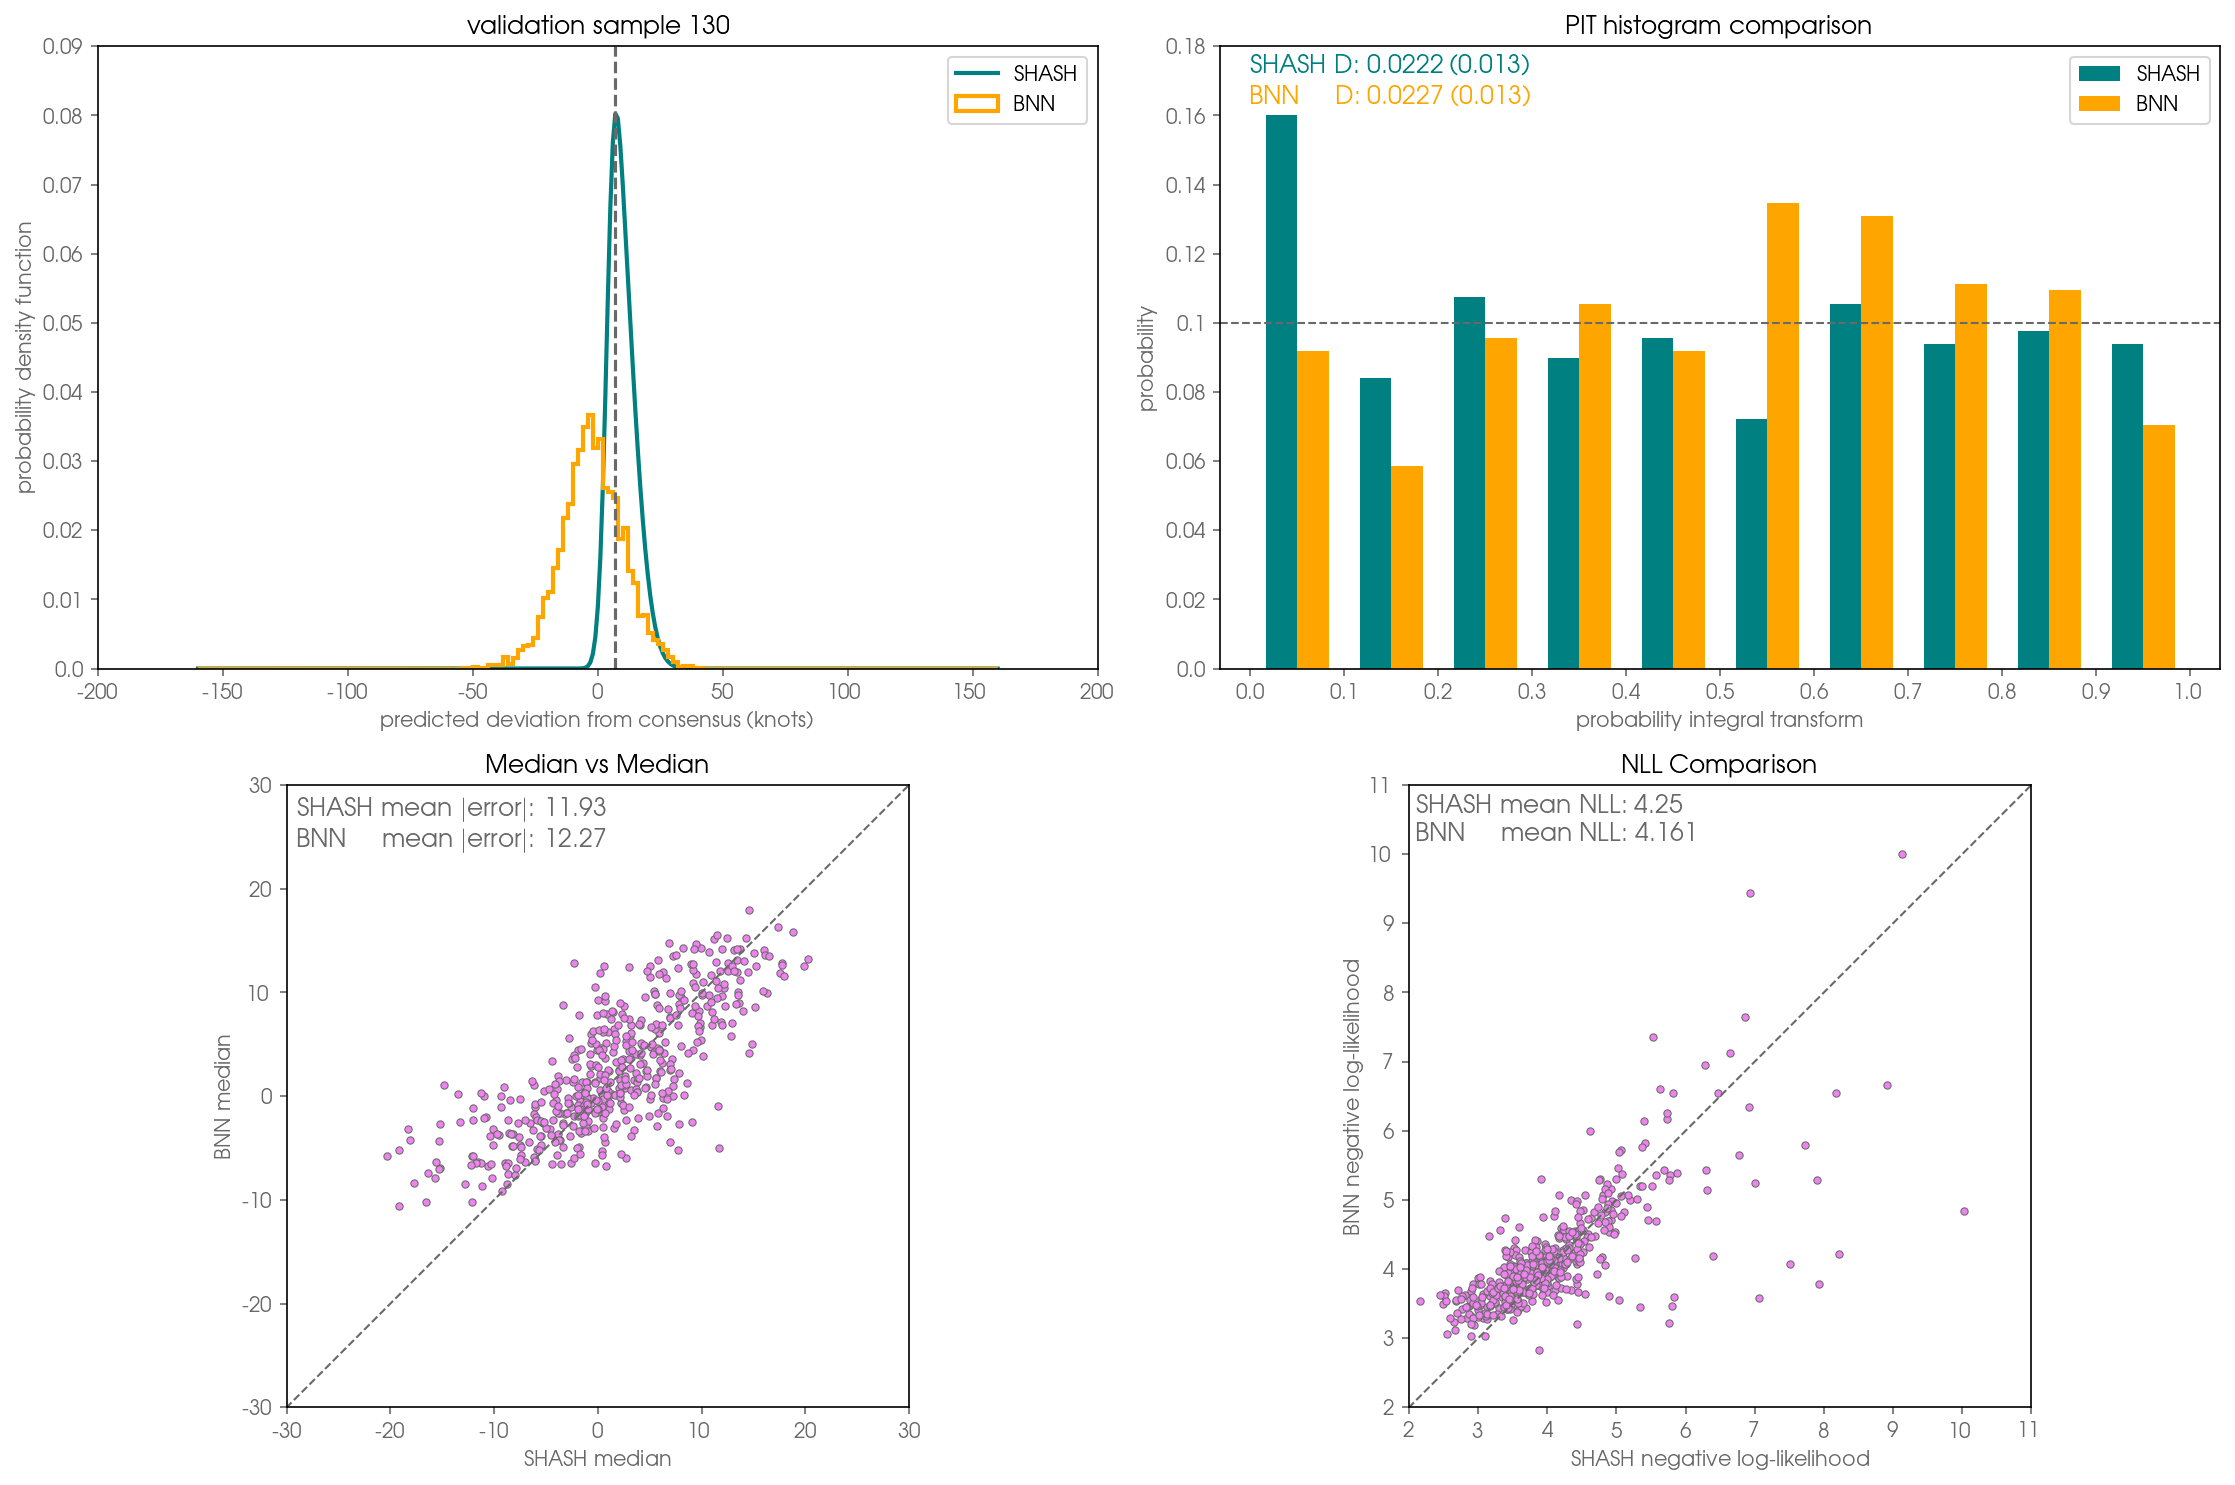

In [8]:
import analysis_plots
import imp
imp.reload(analysis_plots)

f, axs = plt.subplots(2, 2, figsize=(15,10))

# plot sample
ax = axs[0,0]
analysis_plots.plot_sample(ax, onehot_eval, shash_incs, shash_cpd, bnn_cpd)

# plot PITS
ax = axs[0,1]
analysis_plots.plot_pits(ax, x_eval, onehot_eval, model_shash, shash_cpd, bnn_cpd)

# plot median vs median
ax = axs[1,0]
analysis_plots.plot_medians(ax, onehot_eval, shash_cpd, bnn_cpd, shash_med)

# plot NLLs
ax = axs[1,1]
analysis_plots.plot_nlls(ax, x_eval, onehot_eval, model_shash, shash_cpd, bnn_cpd)

plt.tight_layout()

plt.savefig('figures/prediction_plots/comparisonsPanels_outOfSampleAll_' + model_name_shash + '_' + model_name_bnn + '.png', dpi=dpiFig)    
plt.show()

grabbing out of sample CLUSTER
out_of_sample.shape = (70,)


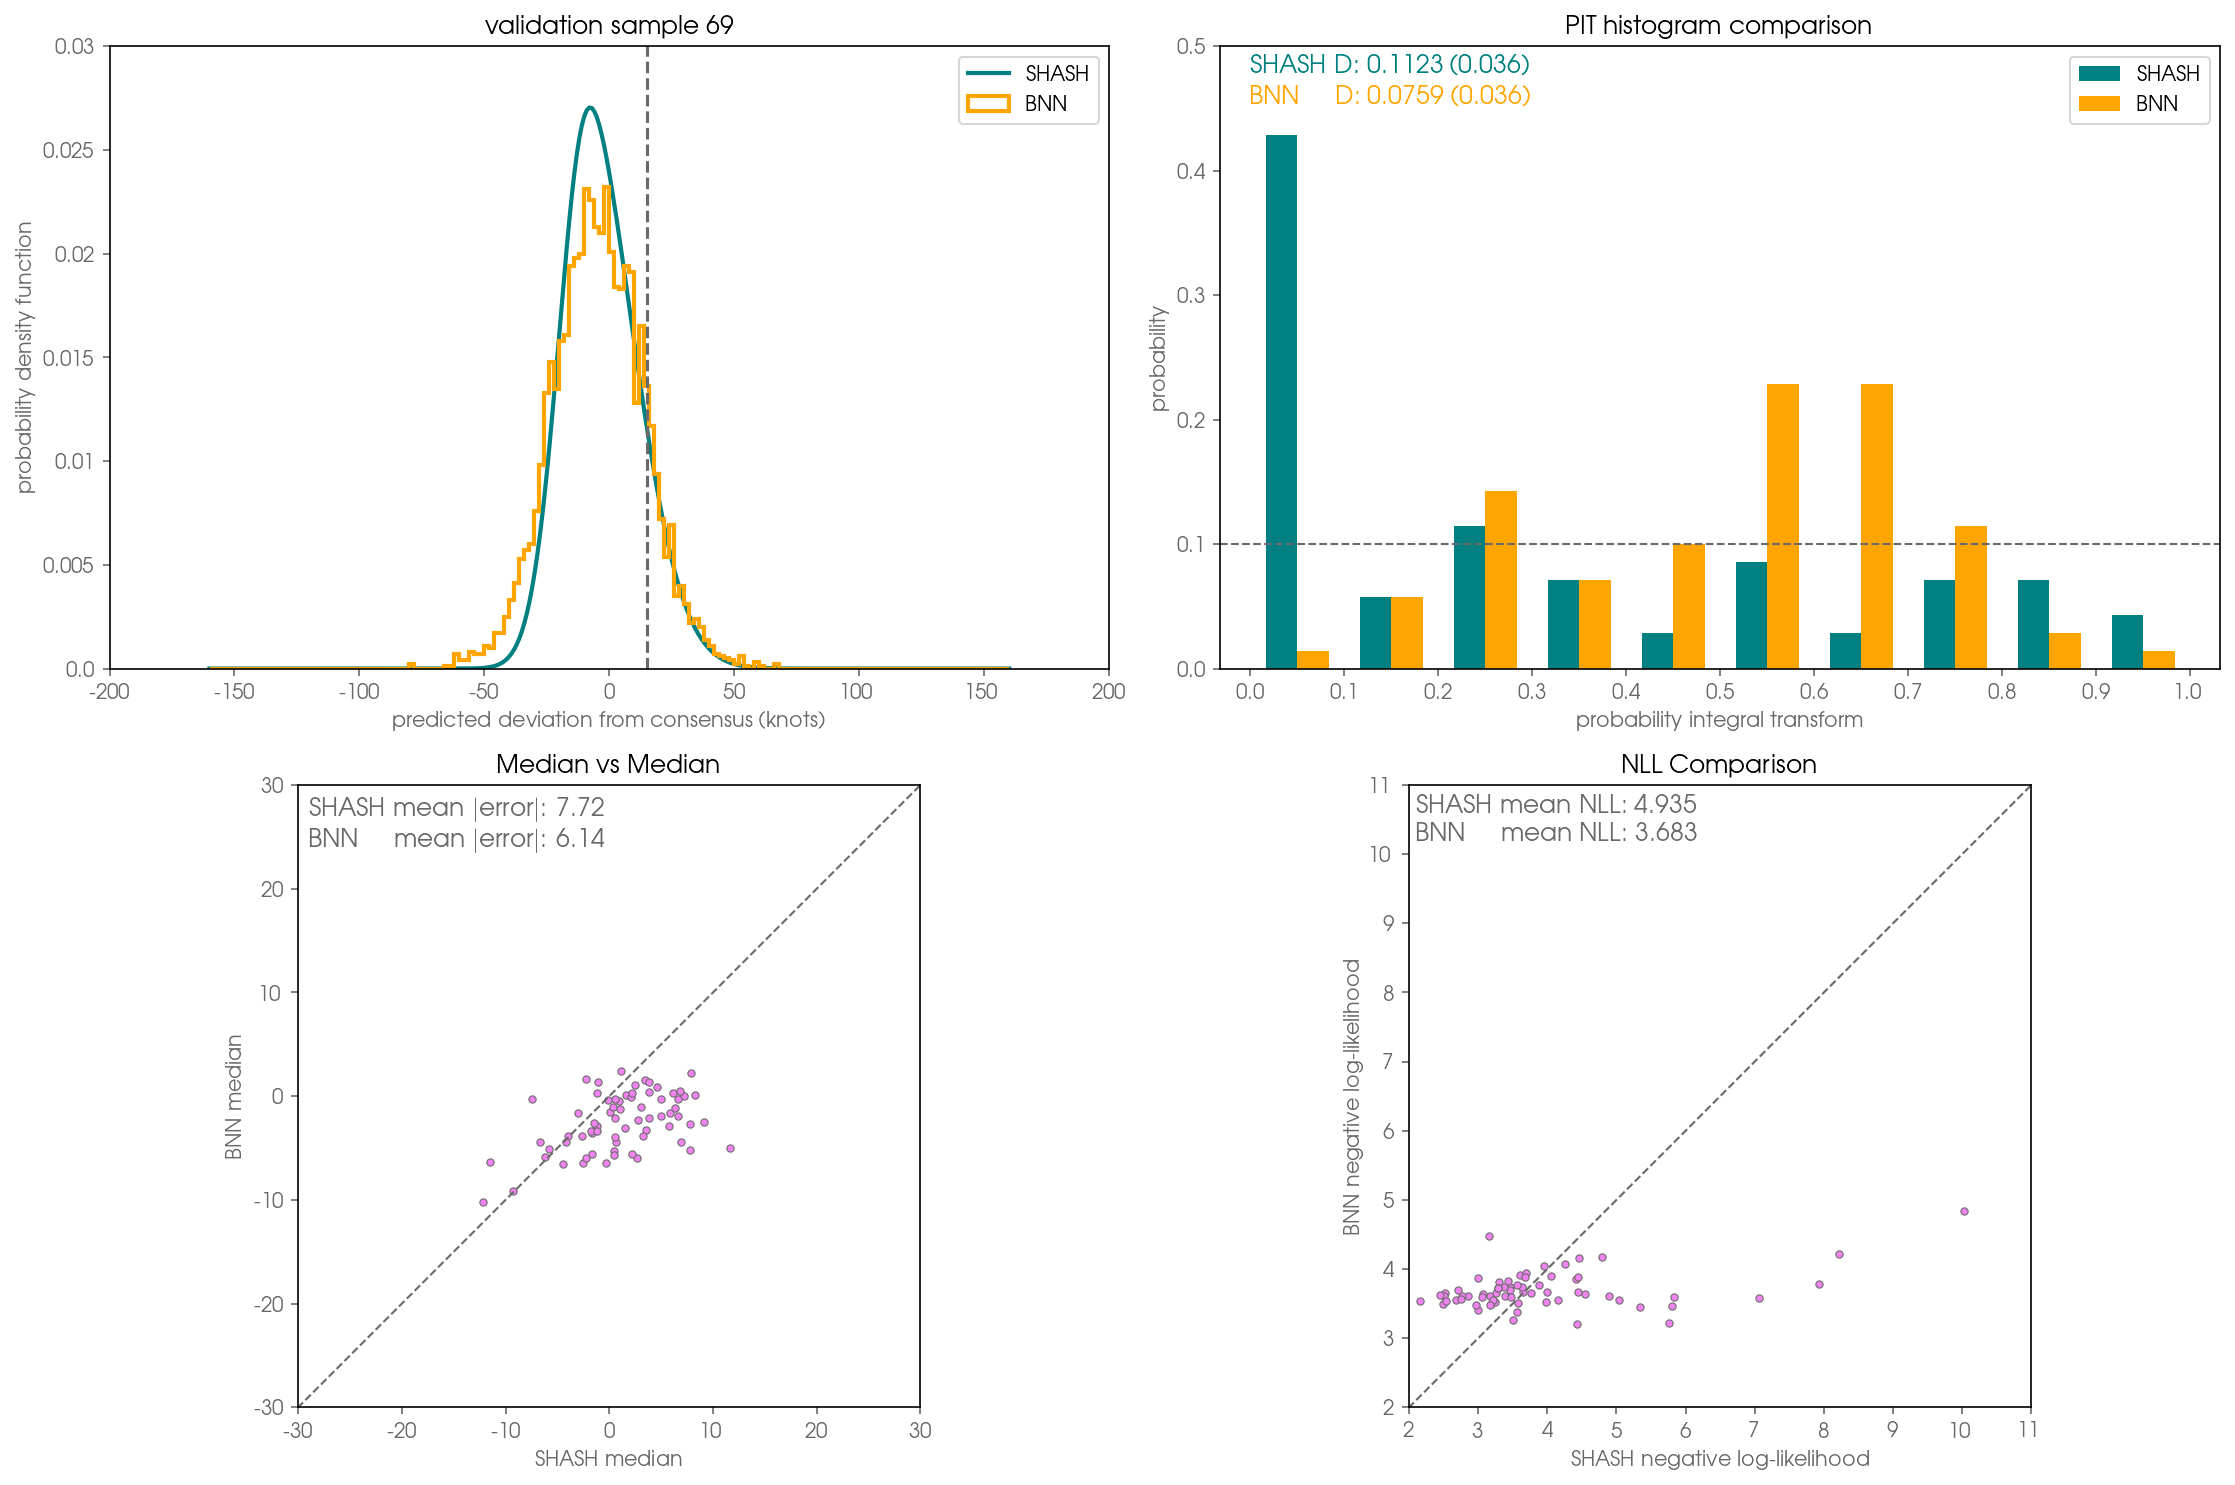

In [9]:
import analysis_plots
import imp
imp.reload(analysis_plots)

# grab out-of-sample samples
if(settings["train_condition"]=='DV12<=15'):
    print('grabbing out of sample ' + 'DV12')
    i_var = data_summary["x_names"].index('DV12')
    i_index = np.where(x_eval[:,i_var]>15)[0] 
elif(settings["train_condition"]=='VMXC<=90'):
    print('grabbing out of sample ' + 'VMXC')
    i_var = data_summary["x_names"].index('VMXC')
    i_index = np.where(x_eval[:,i_var]>90)[0] 
elif(settings["train_condition"]=='cluster'):
    print('grabbing out of sample ' + 'CLUSTER')
    i_index = np.where(data_summary["cluster_eval"] == data_summary["cluster_out"])[0]

print('out_of_sample.shape = ' + str(i_index.shape))
    
f, axs = plt.subplots(2, 2, figsize=(15,10))

# plot sample
ax = axs[0,0]
analysis_plots.plot_sample(ax, onehot_eval[i_index,:], shash_incs, shash_cpd[i_index,:], bnn_cpd[i_index,:])

# plot PITS
ax = axs[0,1]
analysis_plots.plot_pits(ax, x_eval[i_index,:], onehot_eval[i_index,:], model_shash, shash_cpd[i_index,:], bnn_cpd[i_index,:])

# plot median vs median
ax = axs[1,0]
analysis_plots.plot_medians(ax, onehot_eval[i_index,:], shash_cpd[i_index,:], bnn_cpd[i_index,:], shash_med[i_index])

# plot NLLs
ax = axs[1,1]
analysis_plots.plot_nlls(ax, x_eval[i_index,:], onehot_eval[i_index,:], model_shash, shash_cpd[i_index,:], bnn_cpd[i_index,:])

plt.tight_layout()

plt.savefig('figures/prediction_plots/comparisonsPanels_outOfSample_' + model_name_shash + '_' + model_name_bnn + '.png', dpi=dpiFig)    
plt.show()    



In [ ]:
from numpy.random import default_rng
rng = default_rng(12345)

# grab out-of-sample samples
if(settings["train_condition"]=='DV12<=15'):
    print('grabbing out of sample ' + 'DV12')
    i_var = data_summary["x_names"].index('DV12')
    i_index = np.where(x_eval[:,i_var]>15)[0] 
elif(settings["train_condition"]=='VMXC<=90'):
    print('grabbing out of sample ' + 'VMXC')
    i_var = data_summary["x_names"].index('VMXC')
    i_index = np.where(x_eval[:,i_var]>90)[0] 
elif(settings["train_condition"]=='cluster'):
    print('grabbing out of sample ' + 'CLUSTER')
    i_index = np.where(data_summary["cluster_eval"] == data_summary["cluster_out"])[0]

print('out_of_sample.shape = ' + str(i_index.shape))
    
f, axs = plt.subplots(5, 3, figsize=(15,20))
axs = axs.flatten()
random_samples = rng.choice(np.arange(0,len(i_index)),len(axs),replace=False)
for isample, sample in enumerate(random_samples):
    # plot sample
    ax = axs[isample]
    analysis_plots.plot_sample(ax, onehot_eval[i_index,:], shash_incs, shash_cpd[i_index,:], bnn_cpd[i_index,:], sample=sample)
    plt.xlim(-80,80)

plt.tight_layout()
plt.savefig('figures/prediction_plots/comparisonsPanelsLotsofSamples_outOfSample_' + model_name_shash + '_' + model_name_bnn + '.png', dpi=dpiFig)    
plt.show()        

### Corrupted samples

In [10]:
raise ValueError('here')

ValueError: here

In [ ]:
var_corrupt = "VMXC" # "DV12"
i_index = data_summary['x_names'].index(var_corrupt)
plt.hist(x_eval[:,i_index],np.arange(0,130,10))

In [ ]:
print(data_summary['x_names'])
# var_corrupt = "DV12" 
# i_index = data_summary['x_names'].index(var_corrupt)
# x_eval[:,i_index] = 50.
var_corrupt = "VMXC" 
i_index = data_summary['x_names'].index(var_corrupt)
x_eval[:,i_index] = 5.

#--------------------------------------
runs = 5_000
shash_incs = np.arange(-160,161,1)
shash_cpd = np.zeros((np.shape(x_eval)[0],len(shash_incs)))
shash_med = np.zeros((np.shape(x_eval)[0],))
bnn_cpd = np.zeros((np.shape(x_eval)[0],runs))
tf.random.set_seed(network_seed)

# loop through samples for shash calculation and get PDF for each sample
for j in tqdm(range(0,np.shape(shash_cpd)[0])):
    mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params( x_eval[np.newaxis,j], model_shash )
    shash_cpd[j,:] = shash.prob(shash_incs, mu_pred, sigma_pred, gamma_pred, tau_pred)    
    shash_med[j]   = shash.median(mu_pred,sigma_pred,gamma_pred,tau_pred)
    
# loop through runs for bnn calculation    
for i in tqdm(range(0,runs)):
    bnn_cpd[:,i] = np.reshape(model_bnn.predict(x_eval),np.shape(bnn_cpd)[0])
     

In [ ]:
import analysis_plots
import imp
imp.reload(analysis_plots)

f, axs = plt.subplots(2, 2, figsize=(15,10))

# plot sample
ax = axs[0,0]
analysis_plots.plot_sample(ax, onehot_eval, shash_incs, shash_cpd, bnn_cpd, sample=110)

# plot PITS
ax = axs[0,1]
analysis_plots.plot_pits(ax, x_eval, onehot_eval, model_shash, shash_cpd, bnn_cpd)

# plot median vs median
ax = axs[1,0]
analysis_plots.plot_medians(ax, onehot_eval, shash_cpd, bnn_cpd, shash_med)

# plot NLLs
ax = axs[1,1]
analysis_plots.plot_nlls(ax, x_eval, onehot_eval, model_shash, shash_cpd, bnn_cpd)

plt.tight_layout()

plt.savefig('figures/prediction_plots/comparisonsPanels_corruptedSamples_' + var_corrupt + '_' + model_name_shash + '_' + model_name_bnn + '.png', dpi=dpiFig)    
plt.show()